In [1]:
import numpy as np
from numpy.linalg import norm

%matplotlib inline
import matplotlib.pylab as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
def least_squares(x, features, labels):
    """Evaluates the least square function."""
    n_samples, n_features = features.shape
#     print x.shape
#     x = x.reshape(1, n_features)
#     print x.shape
    loss_array = 1/2*(features.dot(x.T) - labels) ** 2
#     print 'loss', loss_array.shape
    return np.sum(loss_array, axis=0)

def least_squares_grad(x, features, labels):
    """Evaluates the gradient of the least square function."""
    n_samples = features.shape[0]
#     x = x.reshape(1, n_features)  # Added for scipy.optimize compatibility
    grad_array = (features.dot(x.T) - labels) * features
#     print 'grad', grad_array.shape
    return np.sum(grad_array, axis=0) / n_samples

def prox_l1(x, l=1.):
    """ Proximal operator of the l1 norm."""
    x_abs = np.abs(x)
    return np.sign(x) * (x_abs - l) * (x_abs > l)

def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0]  # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk)
        err = norm(xk - x_real) / norm(x_real)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
            if it[0] % (n_iter / 5) == 0:
                print ' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

def gd(x_init, grad, n_iter=100, step=1., callback=None):
    """Basic gradient descent algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x -= step * grad(x)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

(2000, 50)
cond = 231.66
Type: linear
n_iter: 50
step size: 1.03
   it    |   obj    |   err   
       0 | 0.00e+00 | 9.11e-01
      10 | 0.00e+00 | 5.26e-01
      20 | 0.00e+00 | 5.05e-01
      30 | 0.00e+00 | 4.87e-01
      40 | 0.00e+00 | 4.71e-01


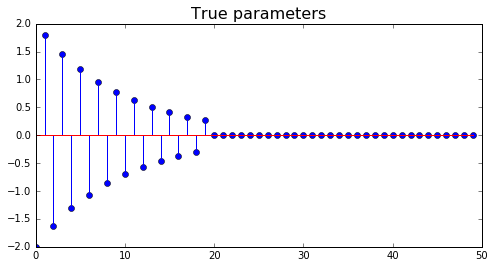

In [12]:
# Generate a fake dataset

n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
diag = np.random.rand(n_features)
features = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

print features.shape

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())

# Change this to 'False' to estimate the logitic regression model.
linear = True
if linear == True:
    residuals = np.random.randn(n_samples, 1)
    labels = features.dot(params.T) + residuals
else:
    labels = np.array([[float(np.random.rand() < p)] for p in logistic(features.dot(params.T))])

# Initialize stuff
x_init = 1 - 2 * np.random.rand(1, n_features)
n_iter = 50
l_l1 = 0
l_l2 = 0.1

# f and gradient
if linear == True:
    f = lambda x: least_squares(x, features, labels)
    grad_f = lambda x: least_squares_grad(x, features, labels)
    step = norm(features.T.dot(features) / n_samples, 2)
else:
    f = lambda x: logistic_loss(x, features, labels)[0]
    grad_f = lambda x: logistic_loss_grad(x, features, labels)
    step = 1. # np.sum(features**2, axis=1).max() / (4 * n_samples)

# g, F and prox.
g = lambda x: l_l1 * np.abs(x).sum()
F = lambda x: f(x) + g(x)
prox_g = lambda x: prox_l1(x, step, l_l1)

print "Type: %s" % ('linear' if linear else 'logistic')
print "n_iter: %d" % n_iter
print "step size: %.2f" % step

# Gradient descent
grad_gd = lambda x: grad_f(x) + l_l1 * np.abs(x)
gd_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_gd = gd(x_init, grad=grad_gd, n_iter=n_iter, step=step, callback=gd_inspector)

plt.figure(figsize=(8, 4))
plt.stem(params[0])
plt.title("True parameters", fontsize=16)
plt.show()